
Beale: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 872 kB 50.4 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=83e281156aeb8a450edc857e10db49a8515fd5bd18369927bbbf1be458877999
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=155adc40433a26337eeed7cd20eaad44412b6058d6aa7ec3541edf64f8f9ceb5
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import t
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Beale'
n_test = 500
eps = 1e-08

util = 'CBM'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - Beale(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2 
                )
       
# Constraints:
lb = -4.5
ub = +4.5

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_lb = 0 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))

In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds          


In [8]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = dim

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]
    
    def CBM(self, y_global_orig, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, y_global_orig, mean, std, ds, dm, nu=3.0):
    
        return self.f(y_global_orig, mean, std, ds, dm, nu=3.0, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.x_best_std)

        x_best_exact = np.empty((n_start, len(self.parameter_key)))
        f_best_exact = np.empty((n_start,))
        opt_exact = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_exact = np.array([res.x for res in opt_exact])
        f_best_exact = np.array([np.atleast_1d(res.fun)[0] for res in opt_exact])
        f_best_min_exact = min(f_best_exact)

        self.x_best_exact = x_best_exact
        self.f_best_exact = f_best_exact
        self.f_best_min_exact = f_best_min_exact
        self.x_best_std_exact = np.std(x_best_exact)
        self.best_exact = x_best_exact[np.argmin(f_best_exact)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_exact)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_exact = str(self.f_best_min_exact)
        x_best_std = str(self.x_best_std)
        x_best_std_exact = str(self.x_best_std_exact)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_exact = BOLD + OKGREEN + x_best_std_exact + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std_exact, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(y_global_orig, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_approx = np.empty((n_start, len(self.parameter_key)))
        f_best_approx = np.empty((n_start,))
        opt_approx = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_approx = np.array([res.x for res in opt_approx])
        f_best_approx = np.array([np.atleast_1d(res.fun)[0] for res in opt_approx])
        f_best_min_approx = min(f_best_approx)

        self.x_best_approx = x_best_approx
        self.f_best_approx = f_best_approx
        self.f_best_min_approx = f_best_min_approx
        self.x_best_std_approx = np.std(x_best_approx)
        self.best_approx = x_best_approx[np.argmin(f_best_approx)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_approx)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_approx = str(self.f_best_min_approx)
        x_best_std = str(self.x_best_std)
        x_best_std_approx = str(self.x_best_std_approx)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_approx = BOLD + OKGREEN + x_best_std_approx + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_approx))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1663328210.4680274

In [13]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_grad(util), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.74680196  1.98292044]	 6.597029498756062	 6.597029498756062	    	    
init	 [-4.49897063 -1.77900685]	 1305.4710589552556	 6.597029498756062	    	    
init	 [-3.17919698 -3.66895265]	 28173.776013477825	 6.597029498756062	    	    
init	 [-2.8236581  -1.38995346]	 237.9931764117774	 6.597029498756062	    	    
init	 [-0.92909273  0.34935061]	 26.1790631757263	 6.597029498756062	    	    
1  	 [-3.53293345  0.8115047 ]	 34.86978538945682	 6.597029498756062	 3.46433914033274	 3.7403983072822213
2  	 [ 4.5        -4.29313086]	 135133.25211281131	 6.597029498756062	 2.59613766665704	 3.345754045454029
3  	 [4.5 4.5]	 174813.36328125	 6.597029498756062	 3.9864416319480447	 4.04261317354814
4  	 [-4.5  4.5]	 169680.83203125	 6.597029498756062	 3.2676415610175735	 3.363429382933622
5	 [2.36679627 0.05993468]	 0.6042027177993303	 0.6042027177993303	 2.772164455659793	 2.5

In [14]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_grad(util), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.57604588 -4.26666391]	 2377.8441741808733	 8.81624267140378	    	    
init	 [ 0.4469623  -0.58209847]	 8.81624267140378	 8.81624267140378	    	    
init	 [-0.71668978 -1.52698661]	 47.3742628518178	 8.81624267140378	    	    
init	 [-2.65816229  1.0734387 ]	 9.08861590265506	 8.81624267140378	    	    
init	 [-1.80310794 -2.09855452]	 510.2220943696988	 8.81624267140378	    	    
1  	 [4.5 4.5]	 174813.36328125	 8.81624267140378	 3.6056898086965936	 3.9903009716272835
2  	 [ 4.5        -2.45848082]	 5545.690842471858	 8.81624267140378	 3.190711259700572	 4.095647940481456
3  	 [-4.5  4.5]	 169680.83203125	 8.81624267140378	 3.105740374695516	 3.971924371834952
4  	 [-4.5 -4.5]	 181853.61328125	 8.81624267140378	 2.2541626852245047	 3.0486514758347836
5  	 [0.07453456 2.78531085]	 27.563967684148643	 8.81624267140378	 2.151690572768047	 2.55914344354313
6	 [3.01678

In [15]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_grad(util), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.45718112 1.8733304 ]	 41.912714742005974	 41.912714742005974	    	    
init	 [-1.88185735  0.09744845]	 47.451188393399434	 41.912714742005974	    	    
init	 [3.53652259 3.5666378 ]	 27475.816689924115	 41.912714742005974	    	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973002421	 41.912714742005974	    	    
init	 [-4.03679517 -0.53271141]	 138.4086524103332	 41.912714742005974	    	    
1  	 [ 2.52283288 -1.74272821]	 259.55509339560894	 41.912714742005974	 2.758508659624749	 3.029362464189536
2  	 [-4.5         2.44836403]	 3905.811021665694	 41.912714742005974	 2.6474215000827694	 4.146075773533726
3  	 [ 4.5 -4.5]	 178131.83203125	 41.912714742005974	 2.895630716384669	 3.776216810003966
4  	 [-1.17485839  4.5       ]	 11084.04184803263	 41.912714742005974	 3.22624863891097	 3.328322099212811
5  	 [-0.15382765 -4.5       ]	 288.12787208278576	 41.9127147420

In [16]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_4= GPGO_multi(surrogate_approx_4, Acquisition_grad(util), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.20326855 0.42509024]	 3.8409856613776237	 3.8409856613776237	    	    
init	 [4.25415924 1.93334394]	 1070.6518137934977	 3.8409856613776237	    	    
init	 [ 1.77955942 -2.55519454]	 1001.3529311398922	 3.8409856613776237	    	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442764963	 3.8409856613776237	    	    
init	 [-2.22315874 -0.58687621]	 67.08861688517413	 3.8409856613776237	    	    
1  	 [-4.5  4.5]	 169680.83203125	 3.8409856613776237	 3.627058343155844	 4.090046942971856
2  	 [-4.5 -4.5]	 181853.61328125	 3.8409856613776237	 4.241766095730238	 3.107535449789448
3  	 [0.88998738 4.37964292]	 6212.320765016894	 3.8409856613776237	 3.164120266961282	 2.9296355243178867
4  	 [0.77932498 0.53220327]	 8.004047315397468	 3.8409856613776237	 2.816725787805422	 2.920344942831067
5  	 [-0.24598283 -4.5       ]	 653.7054221746414	 3.8409856613776237	 3.16131572306

In [17]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_grad(util), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.50206146  3.33659076]	 8263.905568073349	 0.311397019260738	    	    
init	 [-2.6395276   3.76749817]	 19560.15202528338	 0.311397019260738	    	    
init	 [-0.1042993   1.00569477]	 14.186578993925806	 0.311397019260738	    	    
init	 [2.39317071 0.16576189]	 0.311397019260738	 0.311397019260738	    	    
init	 [-1.82879549 -2.81050894]	 2208.9823086257425	 0.311397019260738	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 0.311397019260738	 3.879483434111206	 4.211396857451553
2  	 [4.5 4.5]	 174813.36328125	 0.311397019260738	 4.425635284558393	 3.7737167435275802
3  	 [-4.5 -4.5]	 181853.61328125	 0.311397019260738	 3.379196218531233	 3.814436126188617
4  	 [-4.5         0.16578973]	 121.98579264276603	 0.311397019260738	 2.330420426901939	 3.3171834219272256
5  	 [ 0.95815348 -2.19001257]	 107.59690093806407	 0.311397019260738	 2.143926283064412	 2.7298963482463

In [18]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_grad(util), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.53574136 -1.51218175]	 273.3122030790333	 10.038000709758428	    	    
init	 [ 2.89106211 -4.12473037]	 43803.250406689425	 10.038000709758428	    	    
init	 [-3.53108988  0.85546858]	 29.828433746298536	 10.038000709758428	    	    
init	 [ 0.26835626 -0.73073314]	 10.658925295067505	 10.038000709758428	    	    
init	 [-1.48132936  1.10267489]	 10.038000709758428	 10.038000709758428	    	    
1  	 [4.20133593 1.12711191]	 35.310302628632016	 10.038000709758428	 3.762419580456152	 4.045295156192806
2  	 [-4.5 -4.5]	 181853.61328125	 10.038000709758428	 4.384359912599815	 4.313341925381799
3  	 [1.11727701 4.5       ]	 11268.633630722454	 10.038000709758428	 3.0138692590951606	 3.5524239908909285
4  	 [-4.5  4.5]	 169680.83203125	 10.038000709758428	 3.0022501479083834	 4.120070837355669
5  	 [4.5 4.5]	 174813.36328125	 10.038000709758428	 2.9909612408823207	 3.1

In [19]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_grad(util), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.8132254   2.51926913]	 3321.1422834954587	 2.9676923934097053	    	    
init	 [-0.55431692  2.0111866 ]	 2.9676923934097053	 2.9676923934097053	    	    
init	 [4.30190561 0.34646283]	 6.32173172477085	 2.9676923934097053	    	    
init	 [ 0.01008417 -3.8515398 ]	 11.971894461559128	 2.9676923934097053	    	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.820317186435204	 2.9676923934097053	    	    
1  	 [1.73181974 4.3167746 ]	 20784.448362141437	 2.9676923934097053	 3.507492547681479	 3.8677249414332406
2  	 [ 4.5 -4.5]	 178131.83203125	 2.9676923934097053	 4.019779436871235	 4.077679159699629
3  	 [-4.5 -4.5]	 181853.61328125	 2.9676923934097053	 4.284599450854888	 4.081381363825625
4  	 [-3.5381093  -1.17462676]	 226.89781537510947	 2.9676923934097053	 2.6774183850541804	 2.6774183850541804
5  	 [ 1.19440699 -0.7370009 ]	 4.14226913709253	 2.9676923934097053	

In [20]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_grad(util), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [3.36086463 4.21686597]	 66731.07602386779	 1.8693348557707412	    	    
init	 [3.32275086 0.27770122]	 1.8693348557707412	 1.8693348557707412	    	    
init	 [-2.40544505 -4.39741076]	 45883.361726150484	 1.8693348557707412	    	    
init	 [-0.62578064 -0.87883776]	 26.39306084619828	 1.8693348557707412	    	    
init	 [ 0.20407204 -0.19447384]	 11.649230998110728	 1.8693348557707412	    	    
1  	 [ 3.98297475 -3.55361937]	 35070.39660948274	 1.8693348557707412	 2.6917608486327493	 4.1775436157985135
2  	 [-4.5  4.5]	 169680.83203125	 1.8693348557707412	 3.0111704601490725	 4.039606863055
3  	 [-4.5        -0.36303541]	 150.06058221982462	 1.8693348557707412	 2.7557822038368163	 2.970592187791162
4  	 [-0.54614547  2.57312085]	 38.69979669491389	 1.8693348557707412	 3.185812722735869	 3.0605548438270507
5  	 [-2.40999587  0.92929288]	 19.055934268702586	 1.869334855

In [21]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_grad(util), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.40663262  0.01687133]	 127.7531900635415	 22.479204656276803	    	    
init	 [-0.03804036 -3.29553424]	 22.479204656276803	 22.479204656276803	    	    
init	 [-3.22100023 -2.53297192]	 3783.0538402600087	 22.479204656276803	    	    
init	 [-0.73342638 -2.26708948]	 157.51337782244087	 22.479204656276803	    	    
init	 [-3.74346314 -1.39051224]	 380.7730677650304	 22.479204656276803	    	    
1  	 [2.73365793 4.35023323]	 53339.37070055468	 22.479204656276803	 2.7786502274240776	 2.6909551450303826
2  	 [ 4.49888187 -3.64280031]	 51790.7454303849	 22.479204656276803	 2.7337772367164535	 3.919423153153339
3  	 [-3.23147171  4.5       ]	 86987.47402358249	 22.479204656276803	 2.6335212896794116	 2.9774380839543957
4	 [ 1.46476118 -0.0288966 ]	 1.9646446821347947	 1.9646446821347947	 2.804075530295179	 2.56819500957722
5  	 [4.5        0.56244939]	 2.05707158440044

In [22]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_grad(util), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.44188579 -4.31323246]	 40500.708995062356	 15.229523981513257	    	    
init	 [1.20283411 2.23923494]	 281.8768699287936	 15.229523981513257	    	    
init	 [-0.01343689 -2.47683019]	 15.229523981513257	 15.229523981513257	    	    
init	 [-2.71743422  2.34477641]	 985.5637470908332	 15.229523981513257	    	    
init	 [-2.97800247 -3.70494167]	 26177.1461164703	 15.229523981513257	    	    
1  	 [4.5 4.5]	 174813.36328125	 15.229523981513257	 3.008599634561343	 3.629561060005143
2  	 [ 4.5        -0.23082122]	 24.07836707616832	 15.229523981513257	 2.337164607275677	 3.295004029303269
3  	 [-4.5        -0.28465315]	 146.0405319526674	 15.229523981513257	 2.4311257478509587	 3.8240430675494603
4  	 [-4.5  4.5]	 169680.83203125	 15.229523981513257	 3.0145388140777123	 3.527257537673642
5  	 [-1.01943762  0.14470031]	 29.43555363297914	 15.229523981513257	 2.72457117

In [23]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_grad(util), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.8775728  -4.32472283]	 59421.14819100274	 2.8907294990196846	    	    
init	 [-0.33103326  2.02440536]	 2.8907294990196846	 2.8907294990196846	    	    
init	 [-0.71816756 -0.13115612]	 25.271447350027046	 2.8907294990196846	    	    
init	 [-4.38497267 -0.11365553]	 133.2515796886641	 2.8907294990196846	    	    
init	 [3.97625987 3.1571558 ]	 16859.81677190551	 2.8907294990196846	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 2.8907294990196846	 2.805392947465374	 4.096330748748039
2  	 [-4.5  4.5]	 169680.83203125	 2.8907294990196846	 2.0738787362864515	 3.134685458985447
3  	 [ 2.29214575 -0.50276552]	 4.071665644563369	 2.8907294990196846	 2.9716254939132525	 2.6645072804226713
4  	 [0.50385571 4.5       ]	 2460.795153607628	 2.8907294990196846	 2.6790233057315973	 2.496612397880806
5  	 [ 0.64835819 -2.71704645]	 163.25708946083597	 2.8907294990196846	 2.92067

In [24]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_grad(util), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.11253442  2.16044727]	 746.3412720881302	 48.45196617039589	    	    
init	 [-2.13016486  0.30365454]	 48.45196617039589	 48.45196617039589	    	    
init	 [-4.36882534  3.76872307]	 54651.235607336355	 48.45196617039589	    	    
init	 [ 3.60643369 -4.19920715]	 76007.68460600567	 48.45196617039589	    	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205435	 48.45196617039589	    	    
1  	 [-0.72304443  2.53089834]	 73.02216278592684	 48.45196617039589	 3.9039304993710067	 3.500222542133336
2  	 [4.5 4.5]	 174813.36328125	 48.45196617039589	 4.399841230513107	 3.890861801693242
3  	 [-4.5 -4.5]	 181853.61328125	 48.45196617039589	 2.963311992722151	 3.0921224599979795
4	 [1.74760844 0.21441787]	 1.156084007785007	 1.156084007785007	 2.2445924253015654	 1.7738266342394988
5  	 [-0.36712457 -2.28584395]	 62.2320754932272	 1.156084007785007	 2.4144626516736545	 2.

In [25]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_grad(util), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    	    
1	 [-1.31574815  1.32638362]	 3.468692262868469	 3.468692262868469	 2.4468311110574197	 2.95115396576654
2  	 [-4.5 -4.5]	 181853.61328125	 3.468692262868469	 2.337636942216078	 3.427575978069675
3  	 [-4.5  4.5]	 169680.83203125	 3.468692262868469	 2.504711132376501	 3.452126027220466
4  	 [-0.80511019 -1.7038747 ]	 68.98333534516698	 3.468692262868469	 2.5110032723210676	 3.5407285246477254
5  	 [-4.5         0.00617874]	 131.99291184301413	 3.468692262868469	 3.2031183674981043

In [26]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_grad(util), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.12549009 2.45848547]	 30.19066754742359	 11.367015527968295	    	    
init	 [ 3.33384917 -4.42757746]	 88548.3950659154	 11.367015527968295	    	    
init	 [-1.71237667  4.11843365]	 13933.414320383567	 11.367015527968295	    	    
init	 [ 0.11805041 -1.63544018]	 11.367015527968295	 11.367015527968295	    	    
init	 [ 0.35279944 -2.50870552]	 27.90050047415725	 11.367015527968295	    	    
1  	 [3.00040353 1.62348299]	 217.93014219674217	 11.367015527968295	 3.1734926989865047	 3.5506683232409646
2  	 [-2.62511118 -4.32593681]	 49619.12550875892	 11.367015527968295	 3.6655380561160293	 4.021053283936817
3  	 [-4.5         0.32281655]	 108.76111220724061	 11.367015527968295	 3.293148563684073	 3.560914559650858
4  	 [4.5 4.5]	 174813.36328125	 11.367015527968295	 3.5674288515284114	 3.635250155301607
5  	 [ 4.5        -0.52786552]	 36.322891119263524	 11.367015527

In [27]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_grad(util), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1	 [-4.5        0.9525248]	 20.521657610959743	 20.521657610959743	 3.7394143827984156	 3.959483674074716
2  	 [4.5 4.5]	 174813.36328125	 20.521657610959743	 2.728931078929846	 3.6249475748211584
3  	 [-1.70029506  4.5       ]	 23633.48843666308	 20.521657610959743	 2.9596162493492604	 3.603385371981115
4	 [1.19910456 0.81238664]	 9.299595202144701	 9.299595202144701	 3.012931058334444	 3.5035896743139383
5  	 [-0.43557662 -4.5       ]	 1880.5885930712604	 9.299595202144701	 

In [28]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_grad(util), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.49038029  0.20847007]	 59.442894178636664	 59.442894178636664	    	    
init	 [ 0.45631311 -4.08958245]	 932.9374489641153	 59.442894178636664	    	    
init	 [-1.25344048 -2.49227152]	 594.9494957841517	 59.442894178636664	    	    
init	 [ 1.69853546 -3.02641717]	 2418.389440420566	 59.442894178636664	    	    
init	 [-3.8670762   3.96909774]	 58473.38862292419	 59.442894178636664	    	    
1  	 [4.5 4.5]	 174813.36328125	 59.442894178636664	 4.183957628764965	 4.084862399356945
2  	 [-4.5 -4.5]	 181853.61328125	 59.442894178636664	 3.2723169184207412	 3.4240468691933206
3	 [0.80051803 1.12198577]	 17.323282192044797	 17.323282192044797	 2.4930605965278425	 2.753039269122227
4  	 [ 4.5        -0.44220844]	 31.90275040039772	 17.323282192044797	 2.4140352363380058	 3.5004378034493677
5  	 [ 4.5 -4.5]	 178131.83203125	 17.323282192044797	 1.9171048035016245	 2.920

In [29]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_grad(util), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.84801498  0.2752808 ]	 43.39160388622011	 6.891623366037299	    	    
init	 [-2.77631292 -3.88889678]	 30048.58268621874	 6.891623366037299	    	    
init	 [2.58286914 1.4070017 ]	 81.72560623465196	 6.891623366037299	    	    
init	 [1.23768806 0.68042604]	 6.891623366037299	 6.891623366037299	    	    
init	 [-4.14843375 -1.27967756]	 359.4343933746243	 6.891623366037299	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 6.891623366037299	 2.764074695875593	 4.309058515314868
2  	 [-4.5  4.5]	 169680.83203125	 6.891623366037299	 3.2514891765940193	 3.8872802090682805
3  	 [4.5 4.5]	 174813.36328125	 6.891623366037299	 3.7307992540823482	 2.7344116098041322
4  	 [-0.02484451  3.6191922 ]	 8.026208472379459	 6.891623366037299	 3.2149148490299075	 2.7922173061717928
5  	 [ 0.75675122 -2.1682028 ]	 60.48354924351628	 6.891623366037299	 2.7603224948488214	 2.79416835697249

In [30]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_grad(util), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.35336818 0.04908036]	 2.472652645883837	 2.472652645883837	    	    
init	 [ 3.40741324 -2.86343797]	 7379.017314590048	 2.472652645883837	    	    
init	 [3.17009762 2.25122657]	 1528.3101419799655	 2.472652645883837	    	    
init	 [1.49491501 4.39105903]	 17224.913295283764	 2.472652645883837	    	    
init	 [-2.1872842  -4.24524667]	 31030.348242396165	 2.472652645883837	    	    
1  	 [-4.5         1.95508921]	 819.5000304315288	 2.472652645883837	 3.5346169248968757	 4.052661086491883
2  	 [-1.48389363  0.31641931]	 35.67546012159832	 2.472652645883837	 3.4267144989114806	 4.192544254683748
3  	 [-4.5  4.5]	 169680.83203125	 2.472652645883837	 3.881929683409995	 4.243819884452933
4  	 [-4.5        -0.75241162]	 187.50909339549779	 2.472652645883837	 4.279269592320058	 3.9840615621012567
5  	 [ 4.5        -0.01326551]	 17.9363338169958	 2.472652645883837	 3.77

In [31]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_grad(util), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.62219758  2.35124745]	 1879.409018573639	 63.544086067314716	    	    
init	 [-2.27755824 -3.25681481]	 7496.243410303341	 63.544086067314716	    	    
init	 [-1.51698093 -3.75300391]	 7497.407542620609	 63.544086067314716	    	    
init	 [1.54779373 2.75934418]	 1302.4341957421634	 63.544086067314716	    	    
init	 [4.34467723 1.22094661]	 63.544086067314716	 63.544086067314716	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 63.544086067314716	 3.2349445537999366	 4.279816859418808
2  	 [4.5 4.5]	 174813.36328125	 63.544086067314716	 3.763633059826434	 3.8271824557914096
3	 [ 1.42887609 -0.74230502]	 3.940478524489166	 3.940478524489166	 2.6037241827724817	 2.9835016430836117
4  	 [-1.12586417  4.5       ]	 10153.24368137916	 3.940478524489166	 3.0660796505093617	 3.5068310597537473
5  	 [-1.41135926  1.17024932]	 7.72340687047576	 3.940478524489166	 2.750223173809

In [32]:
### ESTIMATED STP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_grad(util), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.79317721 3.57942355]	 1607.3829986954497	 30.55204392634667	    	    
init	 [3.52377657 2.8425373 ]	 7209.150060592592	 30.55204392634667	    	    
init	 [-4.17699373  1.72581824]	 253.68900136908488	 30.55204392634667	    	    
init	 [-1.09187152  0.16659851]	 30.55204392634667	 30.55204392634667	    	    
init	 [ 1.42156319 -2.75534804]	 963.9362838324588	 30.55204392634667	    	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204392634667	 3.271738085180646	 4.035561152833233
2  	 [ 4.5 -4.5]	 178131.83203125	 30.55204392634667	 2.7994297175703386	 3.8022249263005765
3  	 [-4.5  4.5]	 169680.83203125	 30.55204392634667	 2.7428072956899756	 2.8158028777345354
4	 [ 4.5        -0.35980407]	 28.462188691078254	 28.462188691078254	 2.993495346431561	 2.309174879909931
5	 [1.64496827 0.10636767]	 1.3541771488788457	 1.3541771488788457	 3.013806222751861	 2.773078368488309

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1663328860.319495

In [34]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_grad(util), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.74680196  1.98292044]	 6.597029498756062	 6.597029498756062	    	    
init	 [-4.49897063 -1.77900685]	 1305.4710589552556	 6.597029498756062	    	    
init	 [-3.17919698 -3.66895265]	 28173.776013477825	 6.597029498756062	    	    
init	 [-2.8236581  -1.38995346]	 237.9931764117774	 6.597029498756062	    	    
init	 [-0.92909273  0.34935061]	 26.1790631757263	 6.597029498756062	    	    
1  	 [-3.29292521  0.9940436 ]	 14.750386888478214	 6.597029498756062	 3.46433914033274	 3.7403983072822213
2  	 [4.5 4.5]	 174813.36328125	 6.597029498756062	 2.4869418266964676	 3.342736325196261
3  	 [ 2.96107524 -3.0886303 ]	 8541.44202905192	 6.597029498756062	 2.9217402535369876	 3.9829796163816633
4  	 [-3.51460861  4.5       ]	 103071.72931912485	 6.597029498756062	 3.2234941817026206	 3.6272785280353603
5	 [2.33664629 0.5128022 ]	 0.7734854209144935	 0.7734854209144935	 2

In [35]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_grad(util), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.57604588 -4.26666391]	 2377.8441741808733	 8.81624267140378	    	    
init	 [ 0.4469623  -0.58209847]	 8.81624267140378	 8.81624267140378	    	    
init	 [-0.71668978 -1.52698661]	 47.3742628518178	 8.81624267140378	    	    
init	 [-2.65816229  1.0734387 ]	 9.08861590265506	 8.81624267140378	    	    
init	 [-1.80310794 -2.09855452]	 510.2220943696988	 8.81624267140378	    	    
1  	 [4.5 4.5]	 174813.36328125	 8.81624267140378	 3.6056898086965936	 3.9903009716272835
2  	 [ 4.5        -2.05347305]	 2097.5125880125133	 8.81624267140378	 3.190711259700572	 4.095647940481456
3  	 [-0.59671683  3.71364566]	 776.4322614654162	 8.81624267140378	 3.104641943642623	 3.9260330682751623
4  	 [-4.5 -4.5]	 181853.61328125	 8.81624267140378	 1.826735499874719	 3.7582409449102645
5	 [3.04478215 0.51052883]	 0.00030893508024687597	 0.00030893508024687597	 2.1467124505308197	 3.

In [36]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_grad(util), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.45718112 1.8733304 ]	 41.912714742005974	 41.912714742005974	    	    
init	 [-1.88185735  0.09744845]	 47.451188393399434	 41.912714742005974	    	    
init	 [3.53652259 3.5666378 ]	 27475.816689924115	 41.912714742005974	    	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973002421	 41.912714742005974	    	    
init	 [-4.03679517 -0.53271141]	 138.4086524103332	 41.912714742005974	    	    
1  	 [ 2.52283288 -1.74272821]	 259.55509339560894	 41.912714742005974	 2.758508659624749	 3.029362464189536
2  	 [-3.83738698  3.53153869]	 28235.98177764287	 41.912714742005974	 2.6474215000827694	 4.146075773533726
3	 [-0.05054316 -1.76918193]	 16.013668675061382	 16.013668675061382	 3.047454177311853	 4.012372836110785
4  	 [-0.18976093 -3.93948468]	 214.03278005054008	 16.013668675061382	 2.8364786346376634	 4.107797451085641
5  	 [ 2.9558873  -4.12137429]	 45591.665218704

In [37]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_grad(util), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [4.20326855 0.42509024]	 3.8409856613776237	 3.8409856613776237	    	    
init	 [4.25415924 1.93334394]	 1070.6518137934977	 3.8409856613776237	    	    
init	 [ 1.77955942 -2.55519454]	 1001.3529311398922	 3.8409856613776237	    	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442764963	 3.8409856613776237	    	    
init	 [-2.22315874 -0.58687621]	 67.08861688517413	 3.8409856613776237	    	    
1  	 [-4.5 -4.5]	 181853.61328125	 3.8409856613776237	 3.627058343155844	 4.090046942971856
2  	 [-1.56595897  4.28237238]	 14744.12645523412	 3.8409856613776237	 2.7096303613945767	 3.6235838211493188
3  	 [0.93060757 0.65112371]	 8.126506172671503	 3.8409856613776237	 3.2119290162190612	 3.8477247441144806
4  	 [4.5 4.5]	 174813.36328125	 3.8409856613776237	 3.0273236243217134	 4.048747855962538
5  	 [-4.5         1.45974393]	 55.61031990277605	 3.8409856613776237	 2.2240824

In [38]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_grad(util), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.50206146  3.33659076]	 8263.905568073349	 0.311397019260738	    	    
init	 [-2.6395276   3.76749817]	 19560.15202528338	 0.311397019260738	    	    
init	 [-0.1042993   1.00569477]	 14.186578993925806	 0.311397019260738	    	    
init	 [2.39317071 0.16576189]	 0.311397019260738	 0.311397019260738	    	    
init	 [-1.82879549 -2.81050894]	 2208.9823086257425	 0.311397019260738	    	    
1  	 [4.5 4.5]	 174813.36328125	 0.311397019260738	 3.879483434111206	 4.211396857451553
2  	 [ 3.98913154 -3.49749735]	 32079.59686223533	 0.311397019260738	 3.2621913867544965	 3.882739974304506
3  	 [-4.5 -4.5]	 181853.61328125	 0.311397019260738	 3.3095240843163434	 3.7673871499682243
4  	 [ 0.70128707 -1.83974661]	 21.595271398007547	 0.311397019260738	 2.208338595943343	 3.349898121116112
5  	 [-3.37339481 -0.14089038]	 95.57626442162588	 0.311397019260738	 2.2466023948465685

In [39]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_grad(util), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.53574136 -1.51218175]	 273.3122030790333	 10.038000709758428	    	    
init	 [ 2.89106211 -4.12473037]	 43803.250406689425	 10.038000709758428	    	    
init	 [-3.53108988  0.85546858]	 29.828433746298536	 10.038000709758428	    	    
init	 [ 0.26835626 -0.73073314]	 10.658925295067505	 10.038000709758428	    	    
init	 [-1.48132936  1.10267489]	 10.038000709758428	 10.038000709758428	    	    
1  	 [2.4379287  2.38275885]	 1310.2537204171506	 10.038000709758428	 3.762419580456152	 4.045295156192806
2  	 [-4.5 -4.5]	 181853.61328125	 10.038000709758428	 4.45826779335633	 4.259219732820089
3  	 [-1.71589681  4.5       ]	 24077.912703534523	 10.038000709758428	 3.0075041452263105	 3.612320618310399
4  	 [4.5 4.5]	 174813.36328125	 10.038000709758428	 3.2908186929262397	 3.9728377071126117
5  	 [-0.80122828 -3.04514019]	 720.2869472392365	 10.038000709758428	 1.8882

In [40]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_grad(util), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.8132254   2.51926913]	 3321.1422834954587	 2.9676923934097053	    	    
init	 [-0.55431692  2.0111866 ]	 2.9676923934097053	 2.9676923934097053	    	    
init	 [4.30190561 0.34646283]	 6.32173172477085	 2.9676923934097053	    	    
init	 [ 0.01008417 -3.8515398 ]	 11.971894461559128	 2.9676923934097053	    	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.820317186435204	 2.9676923934097053	    	    
1  	 [1.86107545 4.19484619]	 20236.29977322388	 2.9676923934097053	 3.507492547681479	 3.8677249414332406
2  	 [-4.5 -4.5]	 181853.61328125	 2.9676923934097053	 4.0069594544607385	 4.104245761074804
3  	 [ 4.01220639 -3.62631103]	 40031.114510083346	 2.9676923934097053	 2.9512884663432315	 4.108291328145758
4  	 [-3.5381093  -1.17462676]	 226.89781537510947	 2.9676923934097053	 2.6774367149429517	 2.677580219900779
5  	 [ 1.03304315 -0.51831226]	 4.335194221110227	 2

In [41]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_grad(util), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [3.36086463 4.21686597]	 66731.07602386779	 1.8693348557707412	    	    
init	 [3.32275086 0.27770122]	 1.8693348557707412	 1.8693348557707412	    	    
init	 [-2.40544505 -4.39741076]	 45883.361726150484	 1.8693348557707412	    	    
init	 [-0.62578064 -0.87883776]	 26.39306084619828	 1.8693348557707412	    	    
init	 [ 0.20407204 -0.19447384]	 11.649230998110728	 1.8693348557707412	    	    
1  	 [ 4.36283378 -4.24132271]	 118250.19259523552	 1.8693348557707412	 2.6917608486327493	 4.1775436157985135
2  	 [-4.42522463  2.59724938]	 5535.695265667181	 1.8693348557707412	 2.9979877864488946	 4.012386100319626
3  	 [-1.0657662   4.30509469]	 6891.542319872638	 1.8693348557707412	 2.7401940691055833	 3.7340171016555312
4  	 [-2.92106236 -0.72466131]	 100.29636989100759	 1.8693348557707412	 3.154578281516183	 3.8725882101029567
5  	 [-1.9307964   1.59945738]	 11.8799977

In [42]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_grad(util), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-4.40663262  0.01687133]	 127.7531900635415	 22.479204656276803	    	    
init	 [-0.03804036 -3.29553424]	 22.479204656276803	 22.479204656276803	    	    
init	 [-3.22100023 -2.53297192]	 3783.0538402600087	 22.479204656276803	    	    
init	 [-0.73342638 -2.26708948]	 157.51337782244087	 22.479204656276803	    	    
init	 [-3.74346314 -1.39051224]	 380.7730677650304	 22.479204656276803	    	    
1  	 [2.73365793 4.35023323]	 53339.37070055468	 22.479204656276803	 2.7786502274240776	 2.6909551450303826
2  	 [-2.50174122  3.51176676]	 11358.696468881277	 22.479204656276803	 2.7337772367164535	 3.919423153153339
3  	 [ 4.25647635 -2.99390664]	 14969.763744060918	 22.479204656276803	 2.963124267929696	 4.099598604012571
4	 [0.43734126 0.47301571]	 10.25226219312692	 10.25226219312692	 2.7975127553462396	 3.3007812925733906
5	 [4.37120473 0.69311873]	 0.1100773887334732

In [43]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_grad(util), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.44188579 -4.31323246]	 40500.708995062356	 15.229523981513257	    	    
init	 [1.20283411 2.23923494]	 281.8768699287936	 15.229523981513257	    	    
init	 [-0.01343689 -2.47683019]	 15.229523981513257	 15.229523981513257	    	    
init	 [-2.71743422  2.34477641]	 985.5637470908332	 15.229523981513257	    	    
init	 [-2.97800247 -3.70494167]	 26177.1461164703	 15.229523981513257	    	    
1  	 [4.5 4.5]	 174813.36328125	 15.229523981513257	 3.008599634561343	 3.629561060005143
2  	 [ 4.5        -0.23157151]	 24.101466436435427	 15.229523981513257	 2.337164607275677	 3.295004029303269
3	 [ 1.59211888 -0.44340878]	 2.3789765195949784	 2.3789765195949784	 2.431136270085558	 3.824035830163554
4  	 [-1.04820664 -0.11844297]	 31.42813281372261	 2.3789765195949784	 3.187336689103319	 3.9243338692148075
5  	 [-4.5        -0.08133423]	 136.48764995654827	 2.3789765195949

In [44]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_grad(util), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.8775728  -4.32472283]	 59421.14819100274	 2.8907294990196846	    	    
init	 [-0.33103326  2.02440536]	 2.8907294990196846	 2.8907294990196846	    	    
init	 [-0.71816756 -0.13115612]	 25.271447350027046	 2.8907294990196846	    	    
init	 [-4.38497267 -0.11365553]	 133.2515796886641	 2.8907294990196846	    	    
init	 [3.97625987 3.1571558 ]	 16859.81677190551	 2.8907294990196846	    	    
1  	 [ 3.3799256  -3.21481831]	 14086.238465886821	 2.8907294990196846	 2.805392947465374	 4.096330748748039
2  	 [-2.76283728  2.40869011]	 1230.7881810361032	 2.8907294990196846	 1.9799774605222429	 3.3516590603218606
3  	 [0.57479912 4.104037  ]	 1885.5832941098724	 2.8907294990196846	 2.639431917945938	 3.4478777756659817
4	 [1.8414554  0.11854046]	 0.8226499170248169	 0.8226499170248169	 2.4953936145755975	 3.3714220720522623
5  	 [ 0.32327664 -2.33394132]	 17.04735703408

In [45]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_grad(util), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.11253442  2.16044727]	 746.3412720881302	 48.45196617039589	    	    
init	 [-2.13016486  0.30365454]	 48.45196617039589	 48.45196617039589	    	    
init	 [-4.36882534  3.76872307]	 54651.235607336355	 48.45196617039589	    	    
init	 [ 3.60643369 -4.19920715]	 76007.68460600567	 48.45196617039589	    	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205435	 48.45196617039589	    	    
1  	 [4.5 4.5]	 174813.36328125	 48.45196617039589	 3.9039304993710067	 3.500222542133336
2  	 [-4.5 -4.5]	 181853.61328125	 48.45196617039589	 3.003880464815346	 2.8523709667957546
3  	 [0.39301595 2.12427005]	 52.943534308151584	 48.45196617039589	 2.1676344151535063	 1.9658951530863285
4	 [-0.30833532 -2.16593838]	 44.168147747531144	 44.168147747531144	 2.197595867862042	 2.067280977983209
5	 [2.82087197 0.1664906 ]	 1.0007500721367193	 1.0007500721367193	 2.3467853230972233	 

In [46]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_grad(util), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    	    
1  	 [-1.35286454  0.56962649]	 28.242550788120447	 25.917758071459016	 2.4468311110574197	 2.95115396576654
2  	 [-4.5 -4.5]	 181853.61328125	 25.917758071459016	 2.441987190116833	 3.650715205385069
3  	 [-2.28230984  4.14144068]	 25945.122888354657	 25.917758071459016	 2.6832177285143834	 3.5088248722812723
4  	 [-1.02136422 -2.03826972]	 173.30976176954903	 25.917758071459016	 2.585369918686967	 3.439030928527056
5  	 [-4.35456867  0.17918457]	 115.90686081254319	 25.917758071

In [47]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_grad(util), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.12549009 2.45848547]	 30.19066754742359	 11.367015527968295	    	    
init	 [ 3.33384917 -4.42757746]	 88548.3950659154	 11.367015527968295	    	    
init	 [-1.71237667  4.11843365]	 13933.414320383567	 11.367015527968295	    	    
init	 [ 0.11805041 -1.63544018]	 11.367015527968295	 11.367015527968295	    	    
init	 [ 0.35279944 -2.50870552]	 27.90050047415725	 11.367015527968295	    	    
1  	 [3.14066858 2.55934315]	 3146.3921589521065	 11.367015527968295	 3.1734926989865047	 3.5506683232409646
2  	 [-2.6941295  -4.21852825]	 45178.56413579472	 11.367015527968295	 3.665646524387564	 3.9092634178587637
3  	 [-3.98597549  0.26464016]	 97.85225849348389	 11.367015527968295	 3.2872915778125242	 3.5497488447271635
4  	 [ 3.42979751 -0.41639824]	 12.725841458150368	 11.367015527968295	 3.5628382534983247	 3.6337585607999148
5  	 [-1.15124323  0.32421383]	 29.91441011

In [48]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_grad(util), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1	 [-4.2231993   1.25540485]	 2.484096500444409	 2.484096500444409	 3.7394143827984156	 3.959483674074716
2  	 [4.5 4.5]	 174813.36328125	 2.484096500444409	 2.729145457010295	 3.873282247643215
3  	 [-1.44748373  4.40373081]	 14896.543571017899	 2.484096500444409	 2.9542546109157577	 3.602729511677314
4  	 [1.01800628 1.06184597]	 16.091503438434902	 2.484096500444409	 3.0002075685969634	 3.573179620782242
5  	 [3.82303717 0.35919251]	 3.110298556752162	 2.484096500444409	 2.

In [49]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_grad(util), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.49038029  0.20847007]	 59.442894178636664	 59.442894178636664	    	    
init	 [ 0.45631311 -4.08958245]	 932.9374489641153	 59.442894178636664	    	    
init	 [-1.25344048 -2.49227152]	 594.9494957841517	 59.442894178636664	    	    
init	 [ 1.69853546 -3.02641717]	 2418.389440420566	 59.442894178636664	    	    
init	 [-3.8670762   3.96909774]	 58473.38862292419	 59.442894178636664	    	    
1  	 [4.5 4.5]	 174813.36328125	 59.442894178636664	 4.183957628764965	 4.084862399356945
2  	 [-4.5 -4.5]	 181853.61328125	 59.442894178636664	 3.2723169184207412	 3.4240468691933206
3	 [0.43238816 1.76376643]	 34.19235072476381	 34.19235072476381	 2.4930605965278425	 2.753039269122227
4	 [ 3.89220436 -0.12887117]	 12.4897580946325	 12.4897580946325	 2.3348209972591376	 3.638424490032919
5	 [ 0.92022052 -0.58168592]	 5.016883083372132	 5.016883083372132	 1.8645535265989932	 

In [50]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_grad(util), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.84801498  0.2752808 ]	 43.39160388622011	 6.891623366037299	    	    
init	 [-2.77631292 -3.88889678]	 30048.58268621874	 6.891623366037299	    	    
init	 [2.58286914 1.4070017 ]	 81.72560623465196	 6.891623366037299	    	    
init	 [1.23768806 0.68042604]	 6.891623366037299	 6.891623366037299	    	    
init	 [-4.14843375 -1.27967756]	 359.4343933746243	 6.891623366037299	    	    
1  	 [ 4.35944082 -3.90869006]	 73233.24116839684	 6.891623366037299	 2.764074695875593	 4.309058515314868
2  	 [-0.90022712  4.5       ]	 6393.613761919776	 6.891623366037299	 2.6648927577141457	 3.6476139661092932
3  	 [4.5 4.5]	 174813.36328125	 6.891623366037299	 3.3334820650081456	 3.5298092614619816
4  	 [-3.25955022  2.40832348]	 1760.8006531581464	 6.891623366037299	 3.184601496346539	 3.619397618598302
5  	 [ 0.28809849 -1.76906457]	 9.243305034979912	 6.891623366037299	 2.910

In [51]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_grad(util), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [1.35336818 0.04908036]	 2.472652645883837	 2.472652645883837	    	    
init	 [ 3.40741324 -2.86343797]	 7379.017314590048	 2.472652645883837	    	    
init	 [3.17009762 2.25122657]	 1528.3101419799655	 2.472652645883837	    	    
init	 [1.49491501 4.39105903]	 17224.913295283764	 2.472652645883837	    	    
init	 [-2.1872842  -4.24524667]	 31030.348242396165	 2.472652645883837	    	    
1  	 [-4.40102189  2.56395264]	 5034.984945533792	 2.472652645883837	 3.5346169248968757	 4.052661086491883
2  	 [-1.39526063e+00 -1.28879769e-03]	 37.84335359328037	 2.472652645883837	 3.5382243637430992	 3.5300629176583334
3  	 [4.5 4.5]	 174813.36328125	 2.472652645883837	 3.6533446202190363	 4.2089025953272134
4  	 [-4.14591428 -0.90322948]	 193.81458977101	 2.472652645883837	 2.6514571632064086	 3.766430702306061
5  	 [3.59018804e+00 3.09058933e-03]	 7.050224379985915	 2.47265264

In [52]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_grad(util), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-3.62219758  2.35124745]	 1879.409018573639	 63.544086067314716	    	    
init	 [-2.27755824 -3.25681481]	 7496.243410303341	 63.544086067314716	    	    
init	 [-1.51698093 -3.75300391]	 7497.407542620609	 63.544086067314716	    	    
init	 [1.54779373 2.75934418]	 1302.4341957421634	 63.544086067314716	    	    
init	 [4.34467723 1.22094661]	 63.544086067314716	 63.544086067314716	    	    
1  	 [ 4.24007146 -3.28131847]	 25110.986645769954	 63.544086067314716	 3.2349445537999366	 4.279816859418808
2  	 [4.5 4.5]	 174813.36328125	 63.544086067314716	 3.7627863155579506	 4.063983800455434
3	 [ 0.72463955 -0.47032503]	 6.360776418075002	 6.360776418075002	 2.614042716120477	 2.9956636365099465
4  	 [-1.10477429  4.36344209]	 8070.814129732557	 6.360776418075002	 3.065124027502327	 3.463667387870683
5  	 [-4.5       -0.6829465]	 177.20353051537143	 6.360776418075002	 

In [53]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_grad(util), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.79317721 3.57942355]	 1607.3829986954497	 30.55204392634667	    	    
init	 [3.52377657 2.8425373 ]	 7209.150060592592	 30.55204392634667	    	    
init	 [-4.17699373  1.72581824]	 253.68900136908488	 30.55204392634667	    	    
init	 [-1.09187152  0.16659851]	 30.55204392634667	 30.55204392634667	    	    
init	 [ 1.42156319 -2.75534804]	 963.9362838324588	 30.55204392634667	    	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204392634667	 3.271738085180646	 4.035561152833233
2  	 [ 3.86911059 -0.79159278]	 40.16023603953394	 30.55204392634667	 2.7994297175703386	 3.8022249263005765
3  	 [-2.05277526  4.11642488]	 20137.758854356038	 30.55204392634667	 2.9297368663989856	 4.149752410858977
4  	 [-1.18966029 -2.31106505]	 380.29588743497334	 30.55204392634667	 3.06743747951147	 4.289891125009669
5  	 [4.5 4.5]	 174813.36328125	 30.55204392634667	 2.854794207516509	 4

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact


635.8320150375366

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(-approx_1.GP.y[0:n_init]),-approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(-exact_1.GP.y[0:n_init]),-exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(approx_output_1 - y_global_orig)
regret_exact_1 = np.log(exact_output_1 - y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.5038455118613798, -0.25684845735027423)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(-approx_2.GP.y[0:n_init]),-approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(-exact_2.GP.y[0:n_init]),-exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(approx_output_2 - y_global_orig)
regret_exact_2 = np.log(exact_output_2 - y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-3.1842154495998893, -8.082379399428273)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(-approx_3.GP.y[0:n_init]),-approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(-exact_3.GP.y[0:n_init]),-exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(approx_output_3 - y_global_orig)
regret_exact_3 = np.log(exact_output_3 - y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(-0.22503247863827966, 0.9100827317596442)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(-approx_4.GP.y[0:n_init]),-approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(-exact_4.GP.y[0:n_init]),-exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(approx_output_4 - y_global_orig)
regret_exact_4 = np.log(exact_output_4 - y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(1.345729016312703, 1.345729016312703)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(-approx_5.GP.y[0:n_init]),-approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(-exact_5.GP.y[0:n_init]),-exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(approx_output_5 - y_global_orig)
regret_exact_5 = np.log(exact_output_5 - y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(-1.1666865916873388, -1.1666865916873388)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(-approx_6.GP.y[0:n_init]),-approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(-exact_6.GP.y[0:n_init]),-exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(approx_output_6 - y_global_orig)
regret_exact_6 = np.log(exact_output_6 - y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(0.9826128618870328, -2.056891788191046)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(-approx_7.GP.y[0:n_init]),-approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(-exact_7.GP.y[0:n_init]),-exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(approx_output_7 - y_global_orig)
regret_exact_7 = np.log(exact_output_7 - y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(1.087784678899565, 1.087784678899565)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(-approx_8.GP.y[0:n_init]),-approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(-exact_8.GP.y[0:n_init]),-exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(approx_output_8 - y_global_orig)
regret_exact_8 = np.log(exact_output_8 - y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(0.6255826754918475, 0.6255826754918475)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(-approx_9.GP.y[0:n_init]),-approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(-exact_9.GP.y[0:n_init]),-exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(approx_output_9 - y_global_orig)
regret_exact_9 = np.log(exact_output_9 - y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(0.6753114056296418, -2.2065716266130453)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(-approx_10.GP.y[0:n_init]),-approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(-exact_10.GP.y[0:n_init]),-exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(approx_output_10 - y_global_orig)
regret_exact_10 = np.log(exact_output_10 - y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.7796900943255971, -2.150296286231827)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(-approx_11.GP.y[0:n_init]),-approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(-exact_11.GP.y[0:n_init]),-exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(approx_output_11 - y_global_orig)
regret_exact_11 = np.log(exact_output_11 - y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(0.020261892504984707, -0.19522454301277006)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(-approx_12.GP.y[0:n_init]),-approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(-exact_12.GP.y[0:n_init]),-exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(approx_output_12 - y_global_orig)
regret_exact_12 = np.log(exact_output_12 - y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(0.14503843870406635, 0.000749790973200648)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(-approx_13.GP.y[0:n_init]),-approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(-exact_13.GP.y[0:n_init]),-exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(approx_output_13 - y_global_orig)
regret_exact_13 = np.log(exact_output_13 - y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(1.1235999798931027, 0.856310233846033)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(-approx_14.GP.y[0:n_init]),-approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(-exact_14.GP.y[0:n_init]),-exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(approx_output_14 - y_global_orig)
regret_exact_14 = np.log(exact_output_14 - y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(1.3071469450369828, 0.6478489290767655)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(-approx_15.GP.y[0:n_init]),-approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(-exact_15.GP.y[0:n_init]),-exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(approx_output_15 - y_global_orig)
regret_exact_15 = np.log(exact_output_15 - y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(1.3114942289195557, 0.5612919285025387)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(-approx_16.GP.y[0:n_init]),-approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(-exact_16.GP.y[0:n_init]),-exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(approx_output_16 - y_global_orig)
regret_exact_16 = np.log(exact_output_16 - y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(0.39569943187339984, 0.5320982500941044)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(-approx_17.GP.y[0:n_init]),-approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(-exact_17.GP.y[0:n_init]),-exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(approx_output_17 - y_global_orig)
regret_exact_17 = np.log(exact_output_17 - y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(1.9303066691801607, 1.9303066691801607)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(-approx_18.GP.y[0:n_init]),-approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(-exact_18.GP.y[0:n_init]),-exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(approx_output_18 - y_global_orig)
regret_exact_18 = np.log(exact_output_18 - y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(0.1631909786958628, 0.9052915200747084)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(-approx_19.GP.y[0:n_init]),-approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(-exact_19.GP.y[0:n_init]),-exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(approx_output_19 - y_global_orig)
regret_exact_19 = np.log(exact_output_19 - y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(1.371302168851066, 1.8501504482147593)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(-approx_20.GP.y[0:n_init]),-approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(-exact_20.GP.y[0:n_init]),-exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(approx_output_20 - y_global_orig)
regret_exact_20 = np.log(exact_output_20 - y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(-3.929010727020435, 1.7874230663884931)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

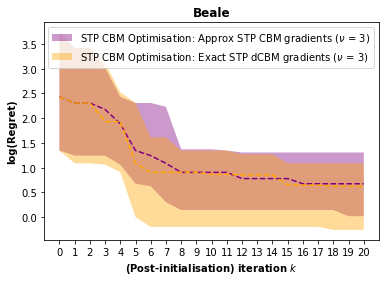

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Purple', ls='--')
plt.plot(median_exact, color = 'Orange', ls='--')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='STP CBM Optimisation: Approx STP CBM gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='STP CBM Optimisation: Exact STP dCBM gradients ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(649.8513162136078, 635.8320150375366)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncApprox_exact_1 = acqFuncApprox(exact_1.history)
acqFuncExact_exact_1 = acqFuncExact(exact_1.history)

e1 = np.std(acqFuncExact_exact_1)
a1 = np.std(acqFuncApprox_exact_1)

e1, a1


(0.23323303455755787, 0.3899719063533603)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncApprox_exact_2 = acqFuncApprox(exact_2.history)
acqFuncExact_exact_2 = acqFuncExact(exact_2.history)

e2 = np.std(acqFuncExact_exact_2)
a2 = np.std(acqFuncApprox_exact_2)

e2, a2


(0.4345272049866981, 0.5396072941827266)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncApprox_exact_3 = acqFuncApprox(exact_3.history)
acqFuncExact_exact_3 = acqFuncExact(exact_3.history)

e3 = np.std(acqFuncExact_exact_3)
a3 = np.std(acqFuncApprox_exact_3)

e3, a3


(0.2760564843583356, 0.4227959369046197)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncApprox_exact_4 = acqFuncApprox(exact_4.history)
acqFuncExact_exact_4 = acqFuncExact(exact_4.history)

e4 = np.std(acqFuncExact_exact_4)
a4 = np.std(acqFuncApprox_exact_4)

e4, a4


(0.4247215160393245, 0.6378924028325123)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncApprox_exact_5 = acqFuncApprox(exact_5.history)
acqFuncExact_exact_5 = acqFuncExact(exact_5.history)

e5 = np.std(acqFuncExact_exact_5)
a5 = np.std(acqFuncApprox_exact_5)

e5, a5


(0.47530318730588217, 0.3566174462830994)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncApprox_exact_6 = acqFuncApprox(exact_6.history)
acqFuncExact_exact_6 = acqFuncExact(exact_6.history)

e6 = np.std(acqFuncExact_exact_6)
a6 = np.std(acqFuncApprox_exact_6)

e6, a6


(0.6563046064034161, 0.4937696452220221)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncApprox_exact_7 = acqFuncApprox(exact_7.history)
acqFuncExact_exact_7 = acqFuncExact(exact_7.history)

e7 = np.std(acqFuncExact_exact_7)
a7 = np.std(acqFuncApprox_exact_7)

e7, a7


(0.47513717601966327, 0.5658771594367659)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncApprox_exact_8 = acqFuncApprox(exact_8.history)
acqFuncExact_exact_8 = acqFuncExact(exact_8.history)

e8 = np.std(acqFuncExact_exact_8)
a8 = np.std(acqFuncApprox_exact_8)

e8, a8


(0.26930691800086964, 0.4544496981281813)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncApprox_exact_9 = acqFuncApprox(exact_9.history)
acqFuncExact_exact_9 = acqFuncExact(exact_9.history)

e9 = np.std(acqFuncExact_exact_9)
a9 = np.std(acqFuncApprox_exact_9)

e9, a9


(0.31081619055061993, 0.3300966421655056)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncApprox_exact_10 = acqFuncApprox(exact_10.history)
acqFuncExact_exact_10 = acqFuncExact(exact_10.history)

e10 = np.std(acqFuncExact_exact_10)
a10 = np.std(acqFuncApprox_exact_10)

e10, a10


(0.300896136700232, 0.2657975125796136)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncApprox_exact_11 = acqFuncApprox(exact_11.history)
acqFuncExact_exact_11 = acqFuncExact(exact_11.history)

e11 = np.std(acqFuncExact_exact_11)
a11 = np.std(acqFuncApprox_exact_11)

e11, a11


(0.4762726543409637, 0.3046049729933761)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncApprox_exact_12 = acqFuncApprox(exact_12.history)
acqFuncExact_exact_12 = acqFuncExact(exact_12.history)

e12 = np.std(acqFuncExact_exact_12)
a12 = np.std(acqFuncApprox_exact_12)

e12, a12


(0.40349982242809646, 0.34525154198485414)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncApprox_exact_13 = acqFuncApprox(exact_13.history)
acqFuncExact_exact_13 = acqFuncExact(exact_13.history)

e13 = np.std(acqFuncExact_exact_13)
a13 = np.std(acqFuncApprox_exact_13)

e13, a13


(0.2917093105194072, 0.3441182922370164)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncApprox_exact_14 = acqFuncApprox(exact_14.history)
acqFuncExact_exact_14 = acqFuncExact(exact_14.history)

e14 = np.std(acqFuncExact_exact_14)
a14 = np.std(acqFuncApprox_exact_14)

e14, a14


(0.36150635831683, 0.28165137290271014)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncApprox_exact_15 = acqFuncApprox(exact_15.history)
acqFuncExact_exact_15 = acqFuncExact(exact_15.history)

e15 = np.std(acqFuncExact_exact_15)
a15 = np.std(acqFuncApprox_exact_15)

e15, a15


(0.4805446628280722, 0.3069945872901405)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncApprox_exact_16 = acqFuncApprox(exact_16.history)
acqFuncExact_exact_16 = acqFuncExact(exact_16.history)

e16 = np.std(acqFuncExact_exact_16)
a16 = np.std(acqFuncApprox_exact_16)

e16, a16


(0.5004606029333478, 0.5062281501555447)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncApprox_exact_17 = acqFuncApprox(exact_17.history)
acqFuncExact_exact_17 = acqFuncExact(exact_17.history)

e17 = np.std(acqFuncExact_exact_17)
a17 = np.std(acqFuncApprox_exact_17)

e17, a17


(0.35896126509304216, 0.5041166575714329)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncApprox_exact_18 = acqFuncApprox(exact_18.history)
acqFuncExact_exact_18 = acqFuncExact(exact_18.history)

e18 = np.std(acqFuncExact_exact_18)
a18 = np.std(acqFuncApprox_exact_18)

e18, a18


(0.529593308157325, 0.4164094218939081)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncApprox_exact_19 = acqFuncApprox(exact_19.history)
acqFuncExact_exact_19 = acqFuncExact(exact_19.history)

e19 = np.std(acqFuncExact_exact_19)
a19 = np.std(acqFuncApprox_exact_19)

e19, a19


(0.47736637584894337, 0.43749217495459874)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncApprox_exact_20 = acqFuncApprox(exact_20.history)
acqFuncExact_exact_20 = acqFuncExact(exact_20.history)

e20 = np.std(acqFuncExact_exact_20)
a20 = np.std(acqFuncApprox_exact_20)

e20, a20


(0.3091005581643946, 0.6869897747799805)

In [120]:
### Summarize arrays: 

exact_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
approx_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(exact_stddev), np.mean(approx_stddev)


(0.40226586867765113, 0.42953662954259847)

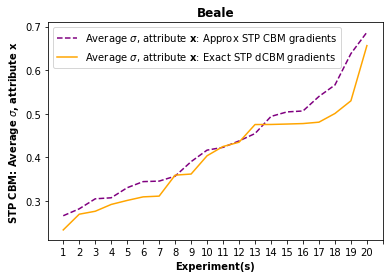

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(approx_stddev, color = 'Purple', ls='--', label='Average $\sigma$, attribute $\mathbf{x}$: Approx STP CBM gradients')
plt.plot(exact_stddev, color = 'Orange', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('STP CBM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualize!
